# Cryptographic Analysis using CPA

In this assignment, we will analyze pre-recorded power traces to extract secret cryptographic key using Correlation Power Analysis (CPA).

The power traces were collected from an FPGA which implemented the cryptographic function:
$$
f(p,k) = \text{SBOX}(p\oplus k), p,k\in \mathbb{Z}_{16}
$$

The output of this function is sampled using Flip-Flops.

### Implementing a CPA script
We'll start by writing some functions for getting HD, HW, and correlation between matrices, which will let us generate the three leakage models, and analyze their relation to the power traces.

In [305]:
import mat73

# Load the plaintext adn power traces
PLAINTEXT = mat73.loadmat("inputs.mat")["plain"]
POWER_TRACES = mat73.loadmat("cmos_exper.mat")["Imat"]

# We translated the SBOX to python instead of dealing with matlab engine - seemed easier
SBOX4 = (12, 5, 6, 11, 9, 0, 10, 13, 3, 14, 15, 8, 4, 7, 1, 2)

Let us write functions to calculate Hamming Distance and Hamming Weight, we'll use those later:

In [306]:
SYMBOL_WIDTH = 4
POSSIBLE_KEYS = [*range(2**SYMBOL_WIDTH)]


def hamming_weight(value: int) -> int:
    assert 0 <= value < 2**SYMBOL_WIDTH, f"{value} is not a symbol in our problem"
    return sum([((value & (1 << i)) != 0) for i in range(SYMBOL_WIDTH)])


def hamming_distance(a: int, b: int) -> int:
    return hamming_weight(a ^ b)

In [ ]:
import numpy as np
from matplotlib import pyplot as plt


def calc_poi_values(plaintext: list) -> list[list[int]]:
    res = []
    for item in plaintext:
        res.append([SBOX4[int(item) ^ key] for key in POSSIBLE_KEYS])
    return res


def calc_poi_power_hw(poi_values: list[list[int]]) -> list[list[int]]:
    res = []
    for row in poi_values:
        res.append([hamming_weight(item) for item in row])
    return res


def calc_poi_power_hd(poi_values: list[list[int]]) -> list[list[int]]:
    res = []
    last_row = [0] * len(poi_values[0])
    for row in poi_values:
        res.append([hamming_distance(item, last_row[i]) for i, item in enumerate(row)])
        last_row = row
    return res


def calculate_correlation_matrix(h, t):
    # Center the matrices by subtracting their means
    h_centered = h - np.mean(h, axis=0, keepdims=True)
    t_centered = t - np.mean(t, axis=0, keepdims=True)

    # Calculate covariance
    cov = h_centered.T @ t_centered

    # Calculate standard deviations
    sigma_h = np.sqrt(np.sum(h_centered**2, axis=0))
    sigma_t = np.sqrt(np.sum(t_centered**2, axis=0))

    # Calculate correlation coefficients
    # Add small epsilon to avoid division by zero
    epsilon = 1e-10
    corr_matrix = cov / (np.outer(sigma_h, sigma_t) + epsilon)

    return corr_matrix


mat_hw = (
    calculate_correlation_matrix(
        calc_poi_power_hw(calc_poi_values(PLAINTEXT)), POWER_TRACES
    ),
)[0]

mat_hd = (
    calculate_correlation_matrix(
        calc_poi_power_hd(calc_poi_values(PLAINTEXT)), POWER_TRACES
    ),
)[0]

mat_val = calculate_correlation_matrix(calc_poi_values(PLAINTEXT), POWER_TRACES)

Now let us create some functions to plot all these graphs:

In [308]:
def maximum_correlation_vs_key_guess_plot(mat: list[list[int]], label: str):
    plt.plot(range(len(mat_val)), [max(np.abs(row)) for row in mat])
    plt.xlabel("Key guess")
    plt.ylabel("Maximum Correlation coefficient (abs value)")
    plt.title("Maximum Correlation coefficient vs. key guess for " + label + " metric")


def correlation_coefficient_vs_sample_for_all_key_guesses_plot(
    mat: list[list[int]], label: str
):
    """
    Show it as a imshow
    """
    lines = []
    for i, row in enumerate(mat):
        lines.append(plt.plot(range(len(row)), np.abs(row), label=f"key={i}"))
    plt.legend()
    plt.xlabel("Sample (time)")
    plt.ylabel("Correlation coefficient (abs value)")
    plt.title(
        "Correlation coefficient vs. sample (time) for all key guesses for "
        + label
        + " metric"
    )


def get_correlation_coefficient_vs_tace_num_for_all_keys(model: list[list[int]]):
    max_correlation = [[] for _ in range(len(POSSIBLE_KEYS))]
    for i in range(len(POWER_TRACES)):
        mat = (
            calculate_correlation_matrix(
                model[: (i + 1)],
                POWER_TRACES[: (i + 1)],
            ),
        )[0]
        for j in range(len(max_correlation)):
            max_correlation[j].append(max(np.abs(mat[j])))
    return max_correlation


def correlation_coefficient_vs_trace_num_for_all_keys(
    model: list[list[int]], label: str
):
    max_correlation = get_correlation_coefficient_vs_tace_num_for_all_keys(model)

    lines = []
    for i, row in enumerate(max_correlation):
        lines.append(plt.plot(range(len(row)), row, label=f"key={i}"))
    plt.legend()
    plt.xlabel("Number of traces")
    plt.ylabel("Max correlation coefficient (abs value)")
    plt.title(
        "Correlation coefficient vs. number of traces for all key guesses "
        + label
        + " metric"
    )


def correlation_ratio_vs_trace_num(model: list[list[int]], label: str):
    max_correlation = get_correlation_coefficient_vs_tace_num_for_all_keys(model)
    
    # The correlation ratio will be - X / Y
    # X - The max correlation coefficient (of the correct key)
    # Y - The 2nd max correlation coefficient (max of the incorrect keys)
    
    sorted_correlations = np.sort(max_correlation, axis=0)[::-1]


    # Avoid division by 0    
    epsilon = 1e-10

    correlation_ratio = sorted_correlations[0] / (sorted_correlations[1] + epsilon)
    plt.plot(range(len(correlation_ratio)), correlation_ratio)
    plt.xlabel("Number of traces")
    plt.ylabel("Correlation Ratio")
    plt.title(
        "Correlation Ratio vs. number of traces for all key guesses "
        + label
        + " metric"
    )
    

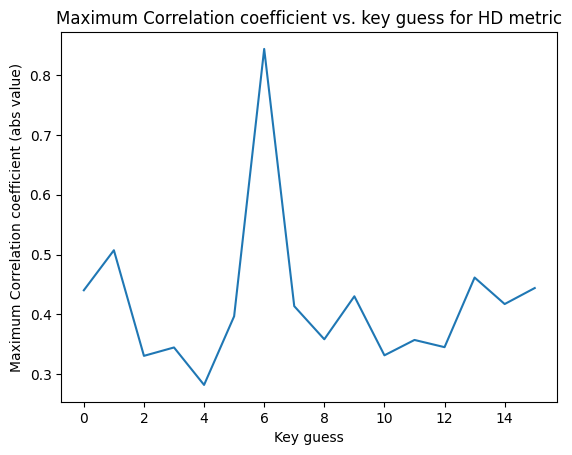

In [309]:
maximum_correlation_vs_key_guess_plot(mat_hd, "HD")

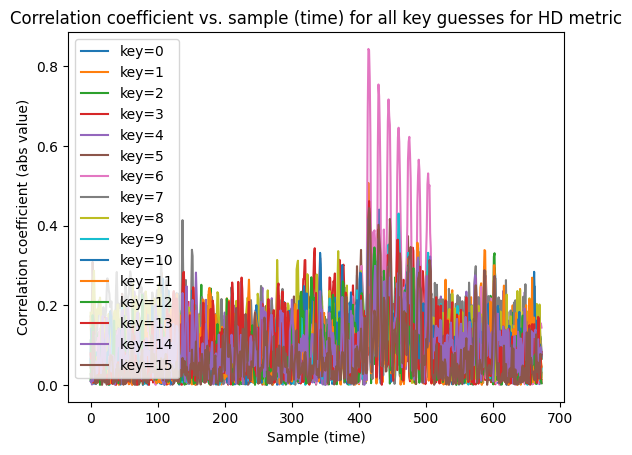

In [310]:
correlation_coefficient_vs_sample_for_all_key_guesses_plot(mat_hd, "HD")

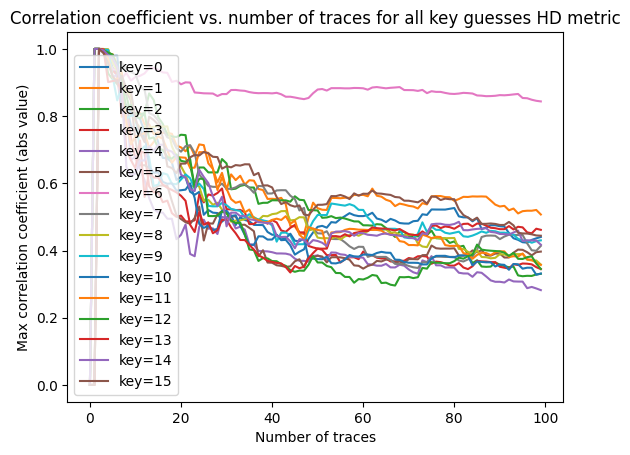

In [311]:
correlation_coefficient_vs_trace_num_for_all_keys(
    calc_poi_power_hd(calc_poi_values(PLAINTEXT)), "HD"
)

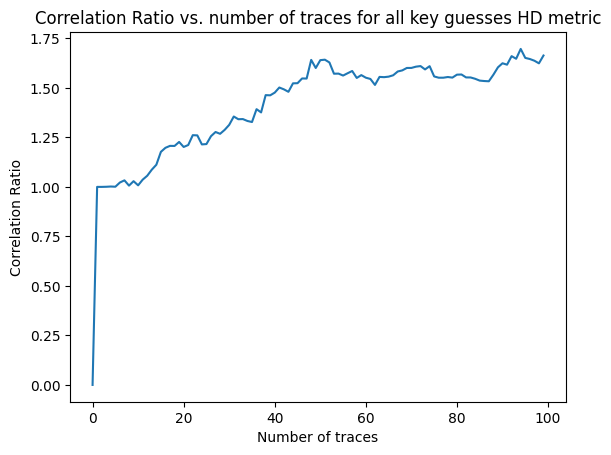

In [312]:
correlation_ratio_vs_trace_num(calc_poi_power_hd(calc_poi_values(PLAINTEXT)), "HD")

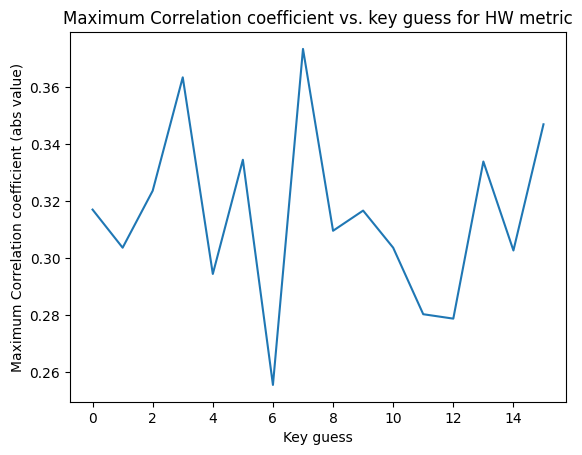

In [313]:
maximum_correlation_vs_key_guess_plot(mat_hw, "HW")

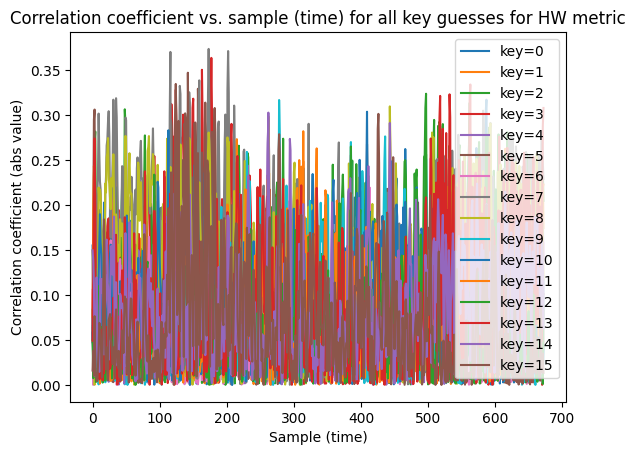

In [314]:
correlation_coefficient_vs_sample_for_all_key_guesses_plot(mat_hw, "HW")

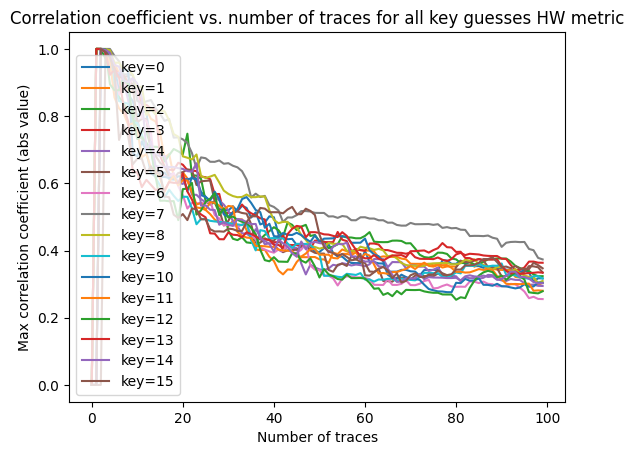

In [315]:
correlation_coefficient_vs_trace_num_for_all_keys(
    calc_poi_power_hw(calc_poi_values(PLAINTEXT)), "HW"
)

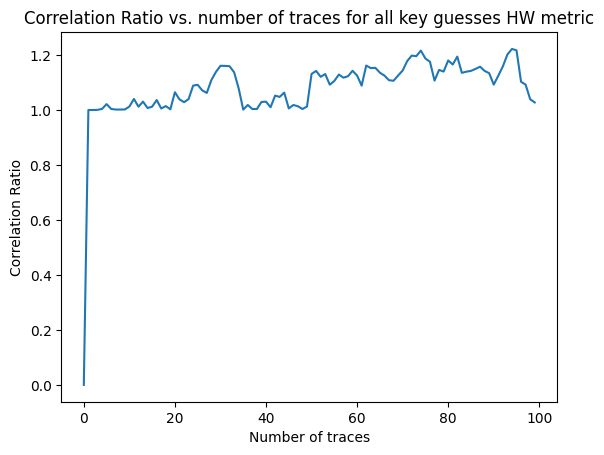

In [316]:
correlation_ratio_vs_trace_num(
    calc_poi_power_hw(calc_poi_values(PLAINTEXT)), "HW"
)

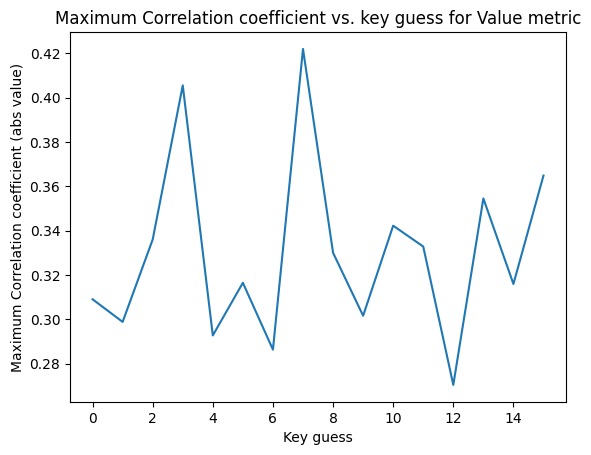

In [317]:
maximum_correlation_vs_key_guess_plot(mat_val, "Value")

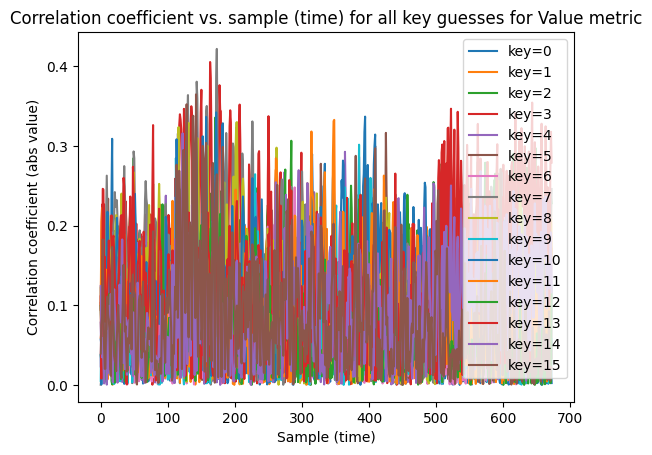

In [318]:
correlation_coefficient_vs_sample_for_all_key_guesses_plot(mat_val, "Value")

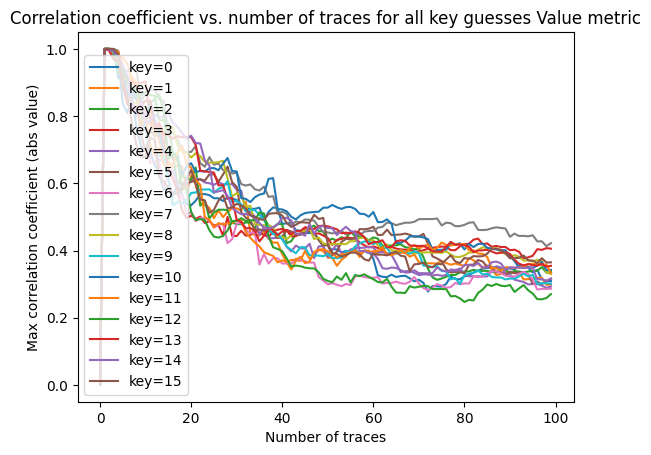

In [319]:
correlation_coefficient_vs_trace_num_for_all_keys(calc_poi_values(PLAINTEXT), "Value")

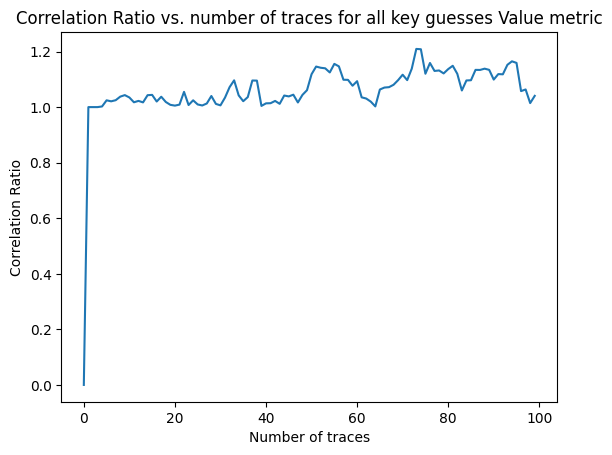

In [320]:
correlation_ratio_vs_trace_num(calc_poi_values(PLAINTEXT), "Value")

The plots of the Value and the HW models, did not yield high correlation coefficients...
However the plots of the HD model, have yield high correlation factor for a key guess of $6$.

It given a $>0.7$ correlation coefficients, we can see the high peaks around 400 in the graph against the samples.

Its maximum correlation coefficient has stabilized on a high value ($>0.8$) after adding more and more traces (up to 100).

The correlation ratio graphs, showed us that the HD model was the best one to distinguish between correct and incorrect keys, as the other models gave correlation ratio of close to 1, the HD model have yielded $>1.6$ which is a good ratio. It gives us good margins to distinguish the correct key.

### iii. Clock Cycle 
The correlation seems highest at the HD model, around $\sim 400$ samples, let us write code to extract the exact sample:

In [321]:
max_index = np.argmax(np.abs(mat_hd))

_, maximum_sample_idx = np.unravel_index(max_index, mat_hd.shape)

print(f"Maximum sample index is {maximum_sample_idx}")

Maximum sample index is 414


Hence the maximum sample index is $414$. Let us reproduce the plot from ii. but now instead of taking the maximum correlation coefficient, we'll take the one at 414.

In [ ]:
def correlation_coefficient_vs_trace_num_for_all_keys_at_poi(
    model: list[list[int]], label: str
):
    max_correlation = [[] for _ in range(len(POSSIBLE_KEYS))]
    for i in range(len(POWER_TRACES)):
        mat = (
            calculate_correlation_matrix(
                model[: (i + 1)],
                POWER_TRACES[: (i + 1)],
            ),
        )[0]
        for j in range(len(max_correlation)):
            max_correlation[j].append(np.abs(mat[j][maximum_sample_idx]))

    lines = []
    for i, row in enumerate(max_correlation):
        lines.append(plt.plot(range(len(row)), row, label=f"key={i}"))
    plt.legend()
    plt.xlabel("Number of traces")
    plt.ylabel("Correlation coefficient (abs value)")
    plt.title(
        "Correlation coefficient at POI vs. number of traces for all key guesses "
        + label
        + " metric"
    )

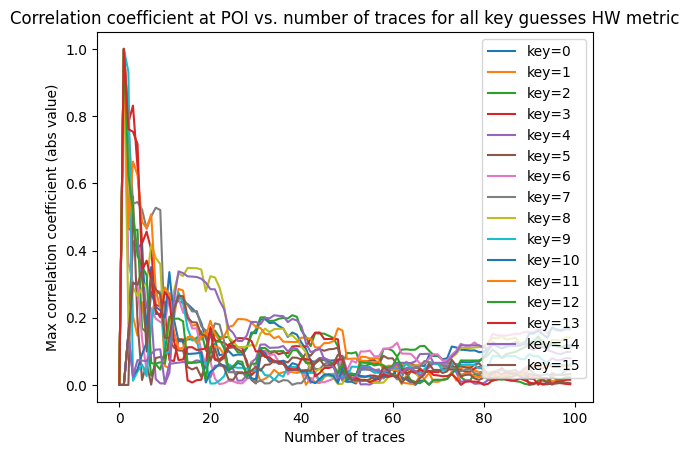

In [323]:
correlation_coefficient_vs_trace_num_for_all_keys_at_poi(
    calc_poi_power_hw(calc_poi_values(PLAINTEXT)), "HW"
)

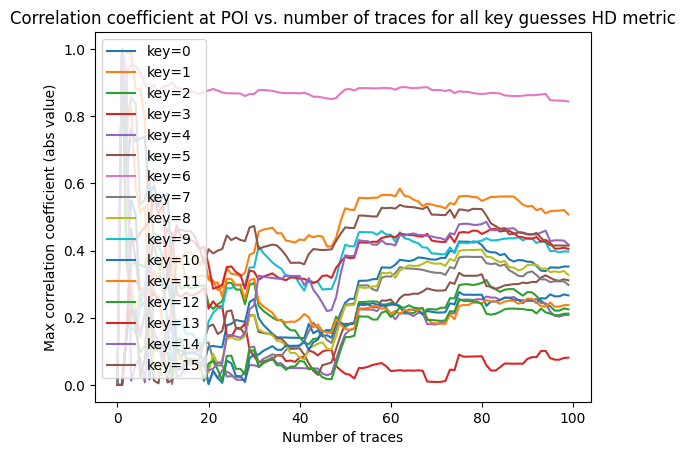

In [324]:
correlation_coefficient_vs_trace_num_for_all_keys_at_poi(
    calc_poi_power_hd(calc_poi_values(PLAINTEXT)), "HD"
)

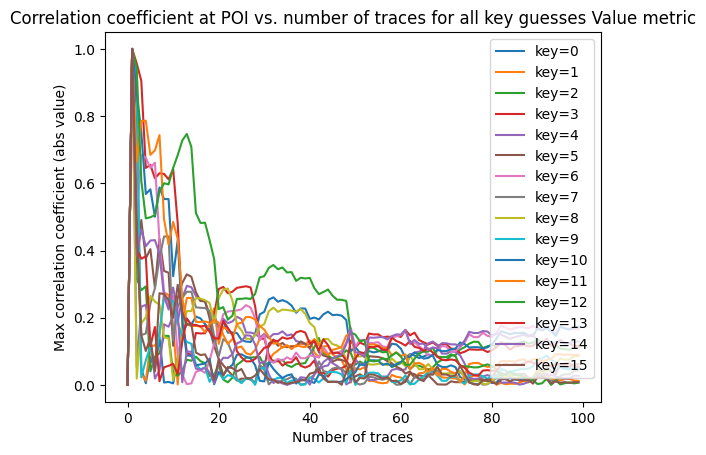

In [325]:
correlation_coefficient_vs_trace_num_for_all_keys_at_poi(
    calc_poi_values(PLAINTEXT), "Value"
)

From here it is easy to see that at the POI, the HW and Value models gave low correlations when accumulating all the traces.

However, for the HD model, we see a very high correlation at the POI for the correct key ($6$).

Also, for the wrong keys, the values are higher coefficients in the HD than in other models, it tells us that he HD is the best-fitting model to the actual power traces, at the POI we could expect to see high values even for wrong keys (for example if only some of the bits were guessed correctly).

### iv. Determining the best-fitting model
From our analysis, the HD model is the best fitting, as it gave us the highest correlation to the power traces ($> 0.7$).

In all the plots we generated, the HD was the best fitting, as we showed before.

Also, we found out that the key is $6$ only using this model. 

### v. Discussion
Using incorrect leakage models on large datasets seems to give us nothing at all.

While the correlation is strong using the HD, other models showed low correlation in all keys, and also the correct key did not lead to the max correlation.

It makes sense, at the end a wrong model would just cancel out over a large dataset, and only lead to low correlation to actual traces.


### Bonus
When attacking a full encryption algorithm, we would have to change the attack process for one main reason, we simply just could not iterate over all keys, in this simple case we had 16 options for key, in real cryptographic function we could be facing $2^{256}$ options.

We will have to build a smarter way to distinguish different parts of the keys, based on the algorithm. 

We probably would have to search each time correlation of different parts of key guesses and generate our predicted power traces according to the affect of this individual bits of the key.

This way we'll break down the complexity of $2^{256}$ options to $16$ options, done $64$ times on different bits.